<a href="https://colab.research.google.com/github/somosnlp/llm-arena/blob/main/Analisis_Linguistico_Arena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.makedirs("/content/drive/MyDrive/graficos_dpo", exist_ok=True)


In [3]:
from google.colab import files
uploaded = files.upload()


Saving dataset_preferencias_dpo_v0.csv to dataset_preferencias_dpo_v0.csv


# Código completo con análisis y visualizaciones

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


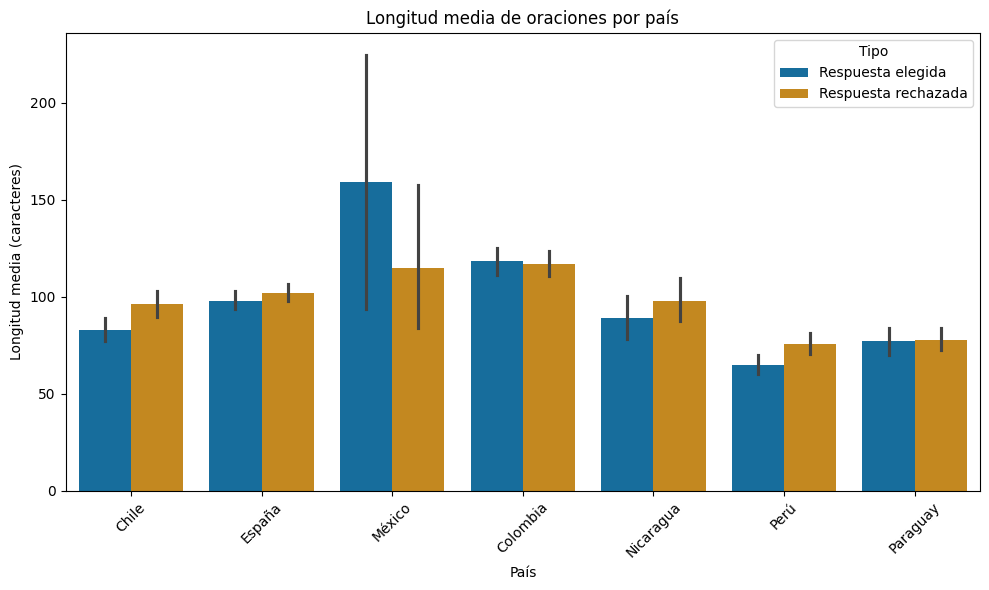

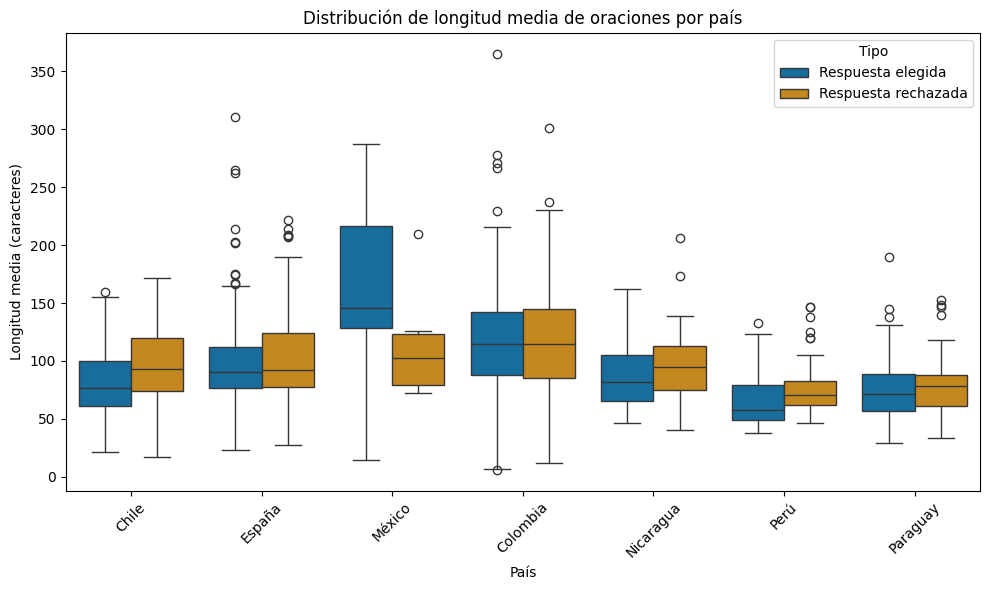

✅ Gráficas guardadas correctamente en tu Google Drive.


In [6]:
# 📦 Instalar y cargar dependencias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize

# 🔽 Descargar recursos para NLTK
nltk.download('punkt_tab')

# 📁 Cargar tu CSV (modifica si subes otro archivo)
df = pd.read_csv("/content/dataset_preferencias_dpo_v0.csv")

# 🧹 Limpiar datos si es necesario (asegúrate de tener estas columnas)
df.dropna(subset=["country", "chosen", "rejected"], inplace=True)

# 📐 Función para calcular longitud media de oraciones
def longitud_media_oraciones(texto):
    oraciones = sent_tokenize(str(texto))
    if len(oraciones) == 0:
        return 0
    longitudes = [len(o) for o in oraciones]
    return sum(longitudes) / len(longitudes)

# 🧮 Aplicar a cada columna
df["chosen_sent_len"] = df["chosen"].apply(longitud_media_oraciones)
df["rejected_sent_len"] = df["rejected"].apply(longitud_media_oraciones)

# 🧱 Reorganizar para visualización
df_long = pd.melt(
    df,
    id_vars="country",
    value_vars=["chosen_sent_len", "rejected_sent_len"],
    var_name="Tipo",
    value_name="Longitud media"
)
df_long["Tipo"] = df_long["Tipo"].map({
    "chosen_sent_len": "Respuesta elegida",
    "rejected_sent_len": "Respuesta rechazada"
})

# 📁 Crear carpeta para guardar las gráficas
import os
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📊 1. Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x="country", y="Longitud media", hue="Tipo", palette="colorblind")
plt.title("Longitud media de oraciones por país")
plt.xlabel("País")
plt.ylabel("Longitud media (caracteres)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/longitud_media_oraciones_barras.png")
plt.show()

# 📈 2. Diagrama de cajas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_long, x="country", y="Longitud media", hue="Tipo", palette="colorblind")
plt.title("Distribución de longitud media de oraciones por país")
plt.xlabel("País")
plt.ylabel("Longitud media (caracteres)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/longitud_media_oraciones_cajas.png")
plt.show()

print("✅ Gráficas guardadas correctamente en tu Google Drive.")



In [7]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
print("👉 Número de filas en df:", df.shape[0])
print("👉 Número de filas en df_long:", df_long.shape[0])
print("👉 Países:", df["country"].unique())
print("👉 Longitud media (chosen):", df["chosen_sent_len"].mean())
print("👉 Longitud media (rejected):", df["rejected_sent_len"].mean())


👉 Número de filas en df: 686
👉 Número de filas en df_long: 1372
👉 Países: ['Chile' 'España' 'México' 'Colombia' 'Nicaragua' 'Perú' 'Paraguay']
👉 Longitud media (chosen): 96.02982208664406
👉 Longitud media (rejected): 100.13469393711416


# Uso de tiempos verbales

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 96.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


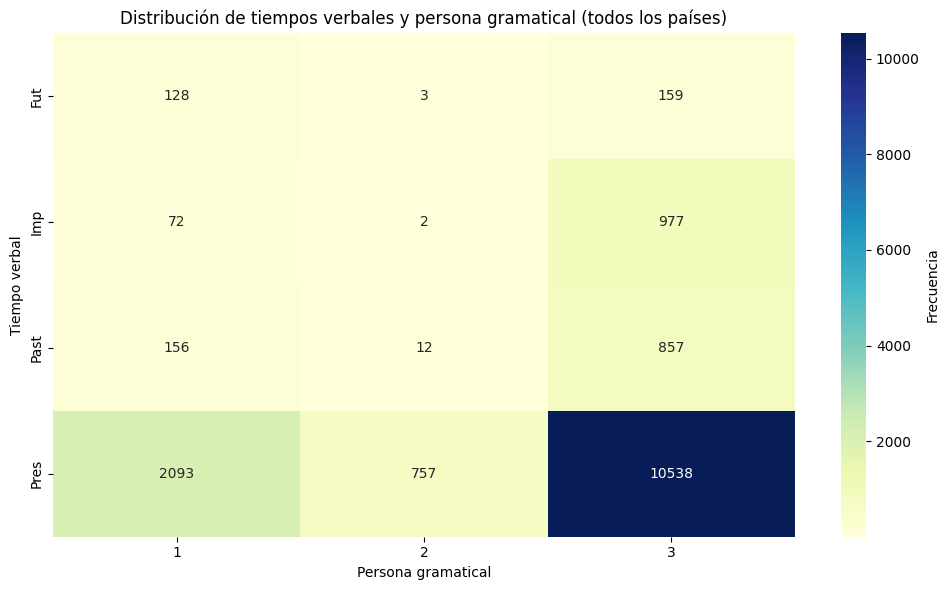

✅ Tabla guardada en: /content/drive/MyDrive/graficos_dpo/tabla_verbos_por_pais.csv
✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/heatmap_tiempos_personas.png


In [9]:
# 📦 Instalar dependencias
!pip install -q spacy
!python -m spacy download es_core_news_sm

import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 📁 Cargar dataset
df = pd.read_csv("/content/dataset_preferencias_dpo_v0.csv")
df.dropna(subset=["country", "chosen", "rejected"], inplace=True)

# 🔠 Cargar modelo spaCy
nlp = spacy.load("es_core_news_sm")

# 🔍 Función para extraer tiempos verbales, persona y formalidad
def analizar_verbos(texto):
    doc = nlp(str(texto))
    resultado = []
    for token in doc:
        if token.pos_ == "VERB":
            tiempo = token.morph.get("Tense")
            persona = token.morph.get("Person")
            if tiempo and persona:
                resultado.append((tiempo[0], persona[0], "verbo"))
        elif token.text.lower() in ["usted", "ustedes"]:
            resultado.append(("—", "2", "formal"))
        elif token.text.lower() in ["tú", "vos", "vosotros"]:
            resultado.append(("—", "2", "informal"))
    return resultado

# 🧮 Procesar todas las respuestas
conteos = []

for i, row in df.iterrows():
    textos = [row["chosen"], row["rejected"]]
    for texto in textos:
        verbos = analizar_verbos(texto)
        for tiempo, persona, tipo in verbos:
            conteos.append({
                "País": row["country"],
                "Tiempo": tiempo,
                "Persona": persona,
                "Tipo": tipo
            })

df_verbos = pd.DataFrame(conteos)

# 🧱 Agrupar conteos por país, tiempo, persona y tipo
tabla = df_verbos.groupby(["País", "Tiempo", "Persona", "Tipo"]).size().reset_index(name="Frecuencia")

# 📁 Guardar tabla en Drive
output_dir = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_dir, exist_ok=True)
tabla.to_csv(f"{output_dir}/tabla_verbos_por_pais.csv", index=False)

# 📊 Visualización: heatmap de tiempos y personas (solo verbos)
pivot = tabla[(tabla["Tipo"] == "verbo")].pivot_table(
    index="Tiempo", columns="Persona", values="Frecuencia", aggfunc="sum", fill_value=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt="d", cbar_kws={"label": "Frecuencia"})
plt.title("Distribución de tiempos verbales y persona gramatical (todos los países)")
plt.xlabel("Persona gramatical")
plt.ylabel("Tiempo verbal")
plt.tight_layout()
plt.savefig(f"{output_dir}/heatmap_tiempos_personas.png")
plt.show()

print("✅ Tabla guardada en:", f"{output_dir}/tabla_verbos_por_pais.csv")
print("✅ Gráfico guardado en:", f"{output_dir}/heatmap_tiempos_personas.png")


# Código Normalizado

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


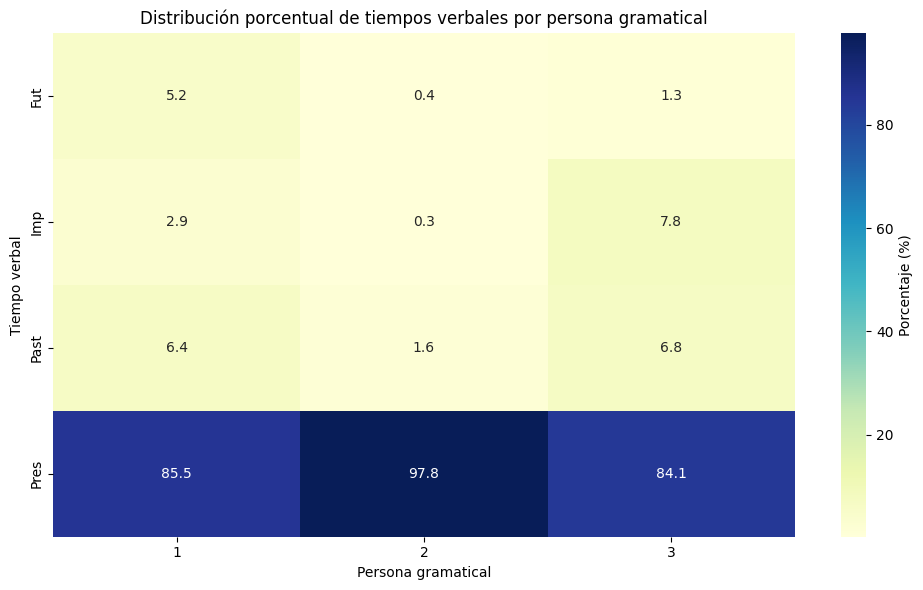

✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/heatmap_porcentual_tiempos_personas.png


In [25]:
# 📦 Instalar dependencias
!pip install -q matplotlib seaborn pandas

# 📚 Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📥 Cargar el archivo desde el entorno
file_path = "/content/tabla_verbos_por_pais.csv"  # Puedes arrastrar tu archivo aquí
df = pd.read_csv(file_path)

# 🧹 Filtrar solo tipo "verbo"
df_verbos = df[df["Tipo"] == "verbo"].copy()

# 📊 Calcular totales por persona
totales_por_persona = df_verbos.groupby("Persona")["Frecuencia"].sum()

# ➗ Calcular porcentajes
df_verbos["Porcentaje"] = df_verbos.apply(
    lambda row: (row["Frecuencia"] / totales_por_persona[row["Persona"]]) * 100, axis=1
)

# 🔄 Pivot table para heatmap
pivot_pct = df_verbos.pivot_table(
    index="Tiempo", columns="Persona", values="Porcentaje", aggfunc="sum", fill_value=0
)

# 🎨 Generar heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_pct, annot=True, cmap="YlGnBu", fmt=".1f", cbar_kws={"label": "Porcentaje (%)"})
plt.title("Distribución porcentual de tiempos verbales por persona gramatical")
plt.xlabel("Persona gramatical")
plt.ylabel("Tiempo verbal")
plt.tight_layout()

# 💾 Guardar en Drive
output_dir = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/heatmap_porcentual_tiempos_personas.png"
plt.savefig(output_path)
plt.show()

print("✅ Gráfico guardado en:", output_path)


# Registro formal vs informal

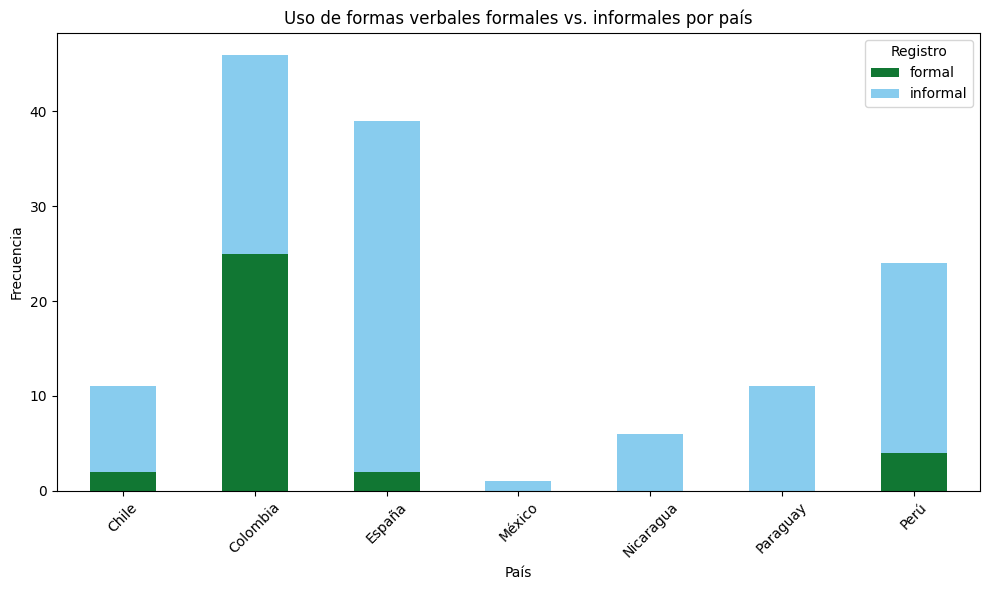

Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/formal_vs_informal_por_pais.png


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Si no tienes esta parte aún en el entorno, define:
df_verbos = pd.DataFrame(conteos)  # (generado previamente con la extracción de tiempos/personas)

# Filtrar solo formal/informal
df_formalidad = df_verbos[df_verbos["Tipo"].isin(["formal", "informal"])].copy()

# Agrupar por país y tipo
conteo_formal = (
    df_formalidad.groupby(["País", "Tipo"])
    .size()
    .reset_index(name="Frecuencia")
)

# Pivot para gráfico apilado
pivot_formal = conteo_formal.pivot(index="País", columns="Tipo", values="Frecuencia").fillna(0)

# Gráfico de barras apiladas (colores aptos para daltónicos)
pivot_formal[['formal', 'informal']].plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=["#117733", "#88CCEE"]  # Colores aptos para daltónicos
)

plt.title("Uso de formas verbales formales vs. informales por país")
plt.xlabel("País")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.legend(title="Registro")
plt.tight_layout()

# 💾 Guardar gráfico
output_dir = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/formal_vs_informal_por_pais.png")
plt.show()

print("Gráfico guardado en:", f"{output_dir}/formal_vs_informal_por_pais.png")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


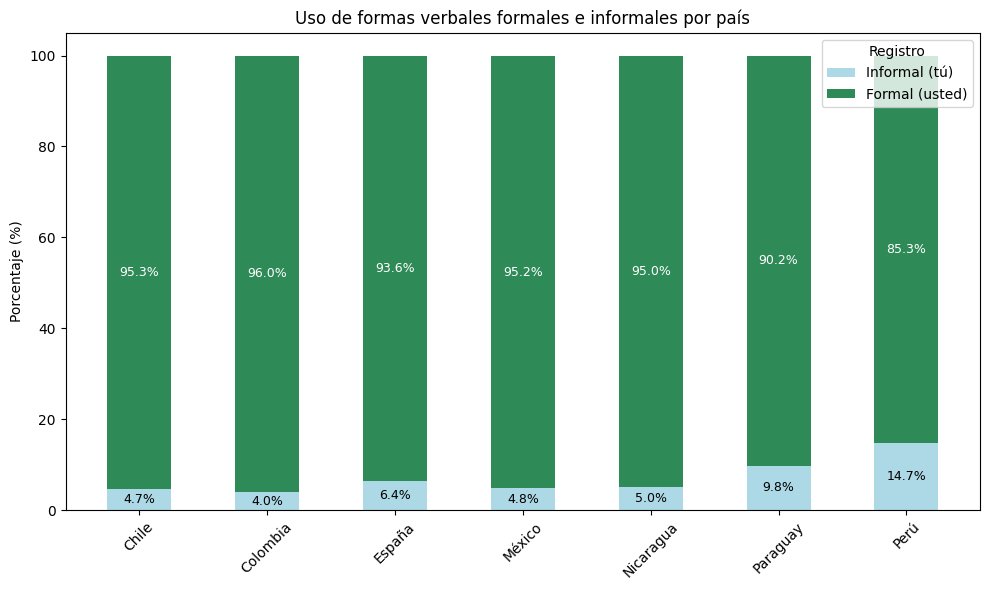

✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/barras_apiladas_2a_persona_formal_informal_por_pais.png


In [17]:
# 📦 Instalar librerías necesarias
!pip install -q pandas matplotlib seaborn

# 📚 Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Ruta de salida
output_dir = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_dir, exist_ok=True)

# 📥 Cargar el archivo CSV con las formas verbales
file_path = "/content/tabla_verbos_por_pais.csv"  # Asegúrate de subir el archivo a Colab
df = pd.read_csv(file_path)

# 🧹 Filtrar sólo 2ª persona formal e informal
df_2a = df[df["Persona"].isin([2, 3])].copy()

# 🏷️ Asignar registro según persona
df_2a["Registro"] = df_2a["Persona"].map({
    2: "Informal (tú)",
    3: "Formal (usted)"
})

# 📊 Agrupar y calcular porcentaje por país
df_grouped = df_2a.groupby(["País", "Registro"])["Frecuencia"].sum().unstack().fillna(0)
df_grouped["Total"] = df_grouped.sum(axis=1)
df_grouped["Informal %"] = (df_grouped["Informal (tú)"] / df_grouped["Total"]) * 100
df_grouped["Formal %"] = (df_grouped["Formal (usted)"] / df_grouped["Total"]) * 100

# 📦 Preparar datos
paises = df_grouped.index.tolist()
informal_pct = df_grouped["Informal %"].tolist()
formal_pct = df_grouped["Formal %"].tolist()

# 🎨 Crear gráfico apilado
plt.figure(figsize=(10, 6))
bars1 = plt.bar(paises, informal_pct, width=0.5, label="Informal (tú)", color="#ADD8E6")
bars2 = plt.bar(paises, formal_pct, width=0.5, bottom=informal_pct, label="Formal (usted)", color="#2E8B57")

# ✏️ Etiquetas de porcentaje
for i in range(len(paises)):
    plt.text(i, informal_pct[i] / 2, f"{informal_pct[i]:.1f}%", ha='center', va='center', color='black', fontsize=9)
    plt.text(i, informal_pct[i] + formal_pct[i] / 2, f"{formal_pct[i]:.1f}%", ha='center', va='center', color='white', fontsize=9)

# 🧾 Personalizar gráfico
plt.ylabel("Porcentaje (%)")
plt.title("Uso de formas verbales formales e informales por país")
plt.xticks(rotation=45)
plt.legend(title="Registro")
plt.tight_layout()

# 💾 Guardar gráfico en Drive
output_path = f"{output_dir}/barras_apiladas_2a_persona_formal_informal_por_pais.png"
plt.savefig(output_path)
plt.show()

print("✅ Gráfico guardado en:", output_path)




In [32]:
import os

file_path = "/content/drive/MyDrive/graficos_dpo/formal_vs_informal_por_tipo_respuesta.png"

if os.path.exists(file_path):
    print("El archivo se ha guardado correctamente.")
else:
    print("❌ El archivo NO se encuentra. Revisa si Drive está montado o si la ruta es correcta.")


❌ El archivo NO se encuentra. Revisa si Drive está montado o si la ruta es correcta.


# Análisis del registro formal vs informal por tipo de respuesta (chosen vs rejected)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 81.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columnas disponibles: ['Verbo', 'Tiempo', 'Persona', 'Tipo', 'Respuesta']


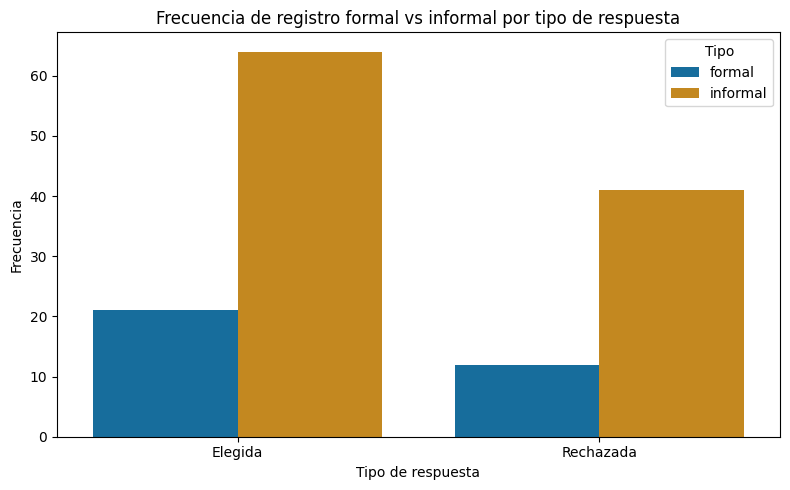

✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo


In [34]:
# 📦 Instalar dependencias necesarias
!pip install -q spacy
!python -m spacy download es_core_news_sm

# 📚 Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import spacy
from collections import Counter

# 🧠 Cargar modelo spaCy en español
nlp = spacy.load("es_core_news_sm")

# 📁 Cargar dataset
df = pd.read_csv("/content/dataset_preferencias_dpo_v0.csv")
df.dropna(subset=["chosen", "rejected"], inplace=True)

# 📂 Crear carpeta en Google Drive
from google.colab import drive
drive.mount("/content/drive")
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 🔍 Función para extraer verbos y su información morfosintáctica
def extraer_verbos(texto, respuesta_tipo):
    doc = nlp(str(texto))
    verbos = []
    for token in doc:
        if token.pos_ == "VERB":
            morph = token.morph
            persona = morph.get("Person")
            tiempo = morph.get("Tense")
            verbos.append({
                "Verbo": token.text,
                "Tiempo": tiempo[0] if tiempo else "desconocido",
                "Persona": persona[0] if persona else "desconocida",
                "Tipo": "verbo",
                "Respuesta": respuesta_tipo
            })
        elif token.text.lower() in ["usted", "ustedes"]:
            verbos.append({
                "Verbo": token.text,
                "Tiempo": "—",
                "Persona": "2",
                "Tipo": "formal",
                "Respuesta": respuesta_tipo
            })
        elif token.text.lower() in ["tú", "vos", "vosotros"]:
            verbos.append({
                "Verbo": token.text,
                "Tiempo": "—",
                "Persona": "2",
                "Tipo": "informal",
                "Respuesta": respuesta_tipo
            })
    return verbos

# 🔁 Procesar todas las respuestas
verbos_chosen = df["chosen"].apply(lambda x: extraer_verbos(x, "Elegida"))
verbos_rejected = df["rejected"].apply(lambda x: extraer_verbos(x, "Rechazada"))

# 🔄 Aplanar y unir listas
todos_verbos = verbos_chosen.tolist() + verbos_rejected.tolist()
flat_list = [item for sublist in todos_verbos for item in sublist]
df_verbos = pd.DataFrame(flat_list)

# ✅ Diagnóstico de columnas
print("Columnas disponibles:", df_verbos.columns.tolist())

# 📊 Tabla de frecuencia por tipo de registro y tipo de respuesta
conteo_registro_tipo = (
    df_verbos[df_verbos["Tipo"].isin(["formal", "informal"])]
    .groupby(["Respuesta", "Tipo"])
    .size()
    .reset_index(name="Frecuencia")
)

# 🎨 Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=conteo_registro_tipo, x="Respuesta", y="Frecuencia", hue="Tipo", palette="colorblind")
plt.title("Frecuencia de registro formal vs informal por tipo de respuesta")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de respuesta")
plt.tight_layout()

# 💾 Guardar gráfico
plt.savefig(f"{output_folder}/registro_formal_informal_por_respuesta.png")
plt.show()

print("✅ Gráfico guardado en:", output_folder)



# Tabla persona y tiempo

In [35]:
import pandas as pd
import spacy
from tqdm import tqdm
tqdm.pandas()

# 📌 Cargar modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

# 🧠 Función para extraer verbos con su morfología
def extraer_verbos(texto, tipo_respuesta):
    doc = nlp(str(texto))
    datos = []
    for token in doc:
        if token.pos_ == "VERB":
            tiempo = token.morph.get("Tense")
            persona = token.morph.get("Person")
            formalidad = "formal" if token.text.lower() in ["usted", "ustedes"] else "informal"
            datos.append({
                "Verbo": token.text,
                "Tiempo": tiempo[0] if tiempo else None,
                "Persona": persona[0] if persona else None,
                "Tipo": formalidad,
                "Respuesta": tipo_respuesta
            })
    return datos

# 🛠️ Aplicar a todo el dataset
verbos_chosen = df["chosen"].progress_apply(lambda x: extraer_verbos(x, "chosen"))
verbos_rejected = df["rejected"].progress_apply(lambda x: extraer_verbos(x, "rejected"))

# 🔗 Aplanar listas y construir df_verbos
lista_verbos = []
for i, lista in enumerate(verbos_chosen):
    for d in lista:
        d["Index"] = i
        lista_verbos.append(d)
for i, lista in enumerate(verbos_rejected):
    for d in lista:
        d["Index"] = i
        lista_verbos.append(d)

df_verbos = pd.DataFrame(lista_verbos)

# ✅ Fusionar para añadir país
df_indices = pd.concat([
    df[["country"]].assign(Respuesta="chosen", Index=df.index),
    df[["country"]].assign(Respuesta="rejected", Index=df.index)
])

df_verbos = df_verbos.merge(df_indices, on=["Respuesta", "Index"], how="left")

print("✅ Filas en df_verbos:", len(df_verbos))
print("📌 Columnas:", df_verbos.columns.tolist())
print("🔍 Países únicos:", df_verbos['country'].unique())


100%|██████████| 686/686 [00:33<00:00, 20.35it/s]

✅ Filas en df_verbos: 29186
📌 Columnas: ['Verbo', 'Tiempo', 'Persona', 'Tipo', 'Respuesta', 'Index', 'country']
🔍 Países únicos: ['Chile' 'España' 'México' 'Colombia' 'Nicaragua' 'Perú' 'Paraguay']


In [36]:
import os

# 📁 Ruta de guardado
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📊 Tabla por país, tiempo y persona
tabla_tiempo_persona = (
    df_verbos.dropna(subset=["country", "Tiempo", "Persona"])  # eliminar nulos
    .groupby(["country", "Tiempo", "Persona"])
    .size()
    .reset_index(name="Frecuencia")
    .sort_values(["country", "Frecuencia"], ascending=[True, False])
)

# 💾 Guardar tabla
csv_path = os.path.join(output_folder, "tabla_tiempo_persona.csv")
tabla_tiempo_persona.to_csv(csv_path, index=False)
print(f"✅ Tabla guardada como CSV en: {csv_path}")


✅ Tabla guardada como CSV en: /content/drive/MyDrive/graficos_dpo/tabla_tiempo_persona.csv


# Heatmap tiempos verbales por país

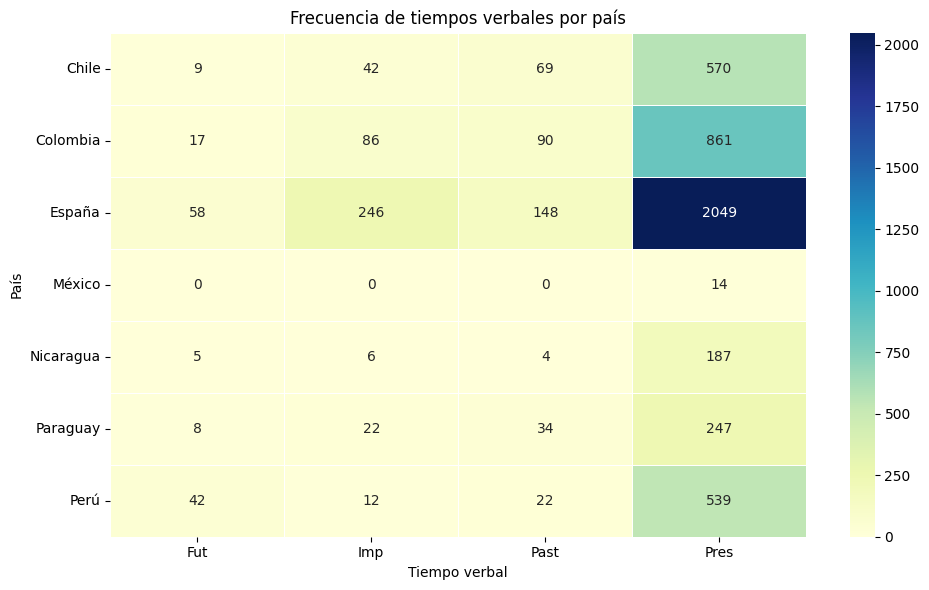

✅ Heatmap guardado en: /content/drive/MyDrive/graficos_dpo/heatmap_tiempos_por_pais.png


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🎨 Crear tabla pivot para heatmap
pivot_heatmap = tabla_tiempo_persona.pivot_table(
    index="country", columns="Tiempo", values="Frecuencia", fill_value=0
)

# 🔥 Visualización si hay datos
if not pivot_heatmap.empty:
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        pivot_heatmap,
        cmap="YlGnBu",  # paleta apta para daltónicos
        annot=True,
        fmt=".0f",
        linewidths=0.5,
        linecolor="white"
    )
    plt.title("Frecuencia de tiempos verbales por país")
    plt.xlabel("Tiempo verbal")
    plt.ylabel("País")
    plt.tight_layout()

    # 💾 Guardar gráfico
    heatmap_path = os.path.join(output_folder, "heatmap_tiempos_por_pais.png")
    plt.savefig(heatmap_path)
    plt.show()
    print(f"✅ Heatmap guardado en: {heatmap_path}")
else:
    print("⚠️ La tabla pivot_heatmap está vacía. No se puede generar el gráfico.")


# Heatmap tiempos verbales por país Normalizado

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


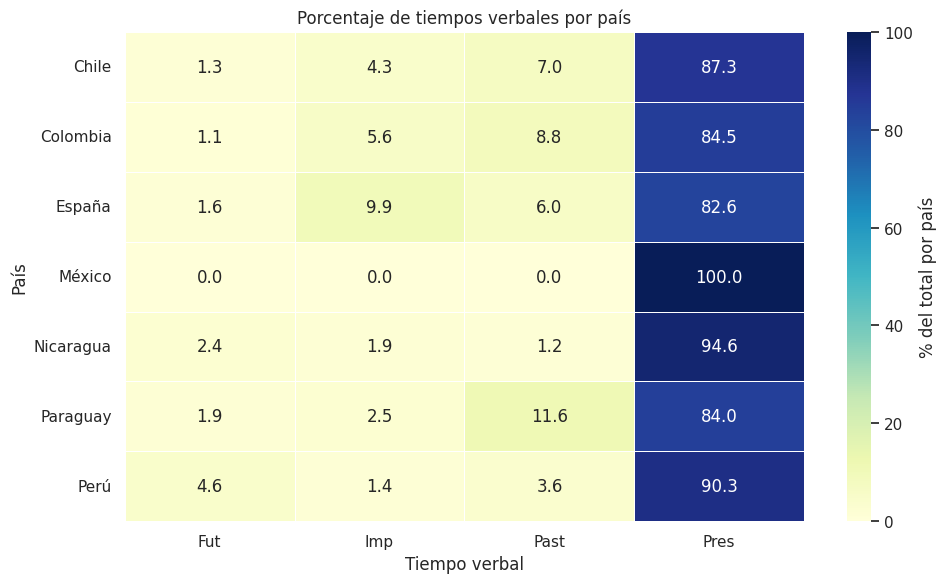

✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/heatmap_tiempos_porcentual.png


In [47]:
# 📦 Instalar dependencias necesarias
!pip install -q pandas seaborn matplotlib

# 📚 Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 📂 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📥 Ruta de archivo
file_path = "/content/drive/MyDrive/graficos_dpo/tabla_verbos_por_pais.csv"  # Ajusta si está en otra carpeta

# 📁 Carpeta de salida
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📑 Cargar datos
df = pd.read_csv(file_path)

# 🧹 Filtrar solo verbos
df_verbos = df[df["Tipo"] == "verbo"]

# 🧮 Agrupar por país y tiempo verbal
resumen_tiempos = df_verbos.groupby(["País", "Tiempo"])["Frecuencia"].sum().reset_index()

# 🧾 Calcular total de verbos por país
totales = resumen_tiempos.groupby("País")["Frecuencia"].sum().reset_index(name="Total")
resumen_tiempos = resumen_tiempos.merge(totales, on="País")
resumen_tiempos["Porcentaje"] = (resumen_tiempos["Frecuencia"] / resumen_tiempos["Total"]) * 100

# 📊 Crear tabla pivot
pivot_heatmap = resumen_tiempos.pivot(index="País", columns="Tiempo", values="Porcentaje").fillna(0)

# 🎨 Graficar heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_heatmap,
    cmap="YlGnBu",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "% del total por país"}
)
plt.title("Porcentaje de tiempos verbales por país")
plt.xlabel("Tiempo verbal")
plt.ylabel("País")
plt.tight_layout()

# 💾 Guardar imagen
output_path = os.path.join(output_folder, "heatmap_tiempos_porcentual.png")
plt.savefig(output_path)
plt.show()

print(f"✅ Gráfico guardado en: {output_path}")


In [39]:
# 📁 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 🗂️ Definir ruta de salida
import os

output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📦 Instalar librerías necesarias (solo si no están)
!pip install -q matplotlib seaborn pandas openpyxl

# 📊 Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🎨 Estilo de gráficos para daltónicos
sns.set_palette("colorblind")
sns.set(style="whitegrid")

# 📥 Cargar CSV
csv_path = "/content/dataset_preferencias_dpo_v0.csv"  # o cambia al path que corresponda si lo subes por el icono a la izquierda
df = pd.read_csv(csv_path)

# 🧹 Comprobación rápida
print(f"✅ Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas")
print("📌 Columnas:", df.columns.tolist())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset cargado con 686 filas y 5 columnas
📌 Columnas: ['country', 'system_prompt', 'question', 'chosen', 'rejected']


# Dataset con estilos narrativo, informativo, discursivo

In [ ]:
import pandas as pd

# 📥 Cargar CSV
df = pd.read_csv("/content/dataset_preferencias_dpo_v0.csv")

# 🧠 Reglas simples por estilo (puedes ajustarlas o ampliarlas)
def detectar_estilo(texto):
    texto = str(texto).lower()
    if any(p in texto for p in ["yo", "mi historia", "una vez", "me pasó"]):
        return "narrativo"
    elif any(p in texto for p in ["usted", "por favor", "cordial", "se recomienda"]):
        return "formal"
    elif any(p in texto for p in ["tú", "oye", "jaja", "bacán", "cachai"]):
        return "informal"
    elif any(p in texto for p in ["describe", "explica", "es", "son", "consiste"]):
        return "descriptivo"
    elif any(p in texto for p in ["creo", "pienso", "considero", "opino"]):
        return "opinativo"
    else:
        return "otro"

# 🏷️ Aplicar reglas a cada texto
df["estilo_chosen"] = df["chosen"].apply(detectar_estilo)
df["estilo_rejected"] = df["rejected"].apply(detectar_estilo)

# ✅ Verifica
print("🎯 Ejemplo de estilos detectados:")
print(df[["chosen", "estilo_chosen", "rejected", "estilo_rejected"]].head())

# 💾 Guardar CSV con estilos
df.to_csv("/content/dataset_con_estilos.csv", index=False)
print("✅ Archivo guardado como: /content/dataset_con_estilos.csv")


🎯 Ejemplo de estilos detectados:
                                              chosen estilo_chosen  \
0  ¡Uf, compadre! Caminando por Estación Central ...   descriptivo   
1  ¡Hola! Muy bien, gracias por preguntar. ¿En qu...          otro   
2  ¡Qué situación más particular! A ver, consider...     narrativo   
3  El Festival de Viña del Mar es uno de los even...   descriptivo   
4  Como Viñamarino de toda la vida y estando en e...   descriptivo   

                                            rejected estilo_rejected  
0  En una situación así, la sensación que podrías...     descriptivo  
1  Hola, estoy bien, gracias. ¿En qué puedo ayuda...     descriptivo  
2  Basado en lo que se conoce sobre el fenómeno d...       narrativo  
3  Como asistente de lenguaje, no tengo una nacio...     descriptivo  
4  En el Festival de Viña del Mar, la reacción de...     descriptivo  
✅ Archivo guardado como: /content/dataset_con_estilos.csv


# Gráfico de radar por país y estilo

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# 🧭 Ruta de guardado en Drive
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📥 Cargar el CSV con los estilos detectados
df = pd.read_csv("/content/dataset_con_estilos.csv")

# 🧱 Unir estilos y países
df_estilos = pd.concat([
    pd.DataFrame({
        "País": df["country"],
        "Estilo": df["estilo_chosen"],
        "Origen": "chosen"
    }),
    pd.DataFrame({
        "País": df["country"],
        "Estilo": df["estilo_rejected"],
        "Origen": "rejected"
    })
], ignore_index=True)

# 🧮 Conteo de estilos por país
tabla_estilos = (
    df_estilos
    .groupby(["País", "Estilo"])
    .size()
    .reset_index(name="Frecuencia")
)

# 🧠 Lista de estilos (ejes del radar)
estilos = sorted(tabla_estilos["Estilo"].dropna().unique().tolist())

# 🔁 Generar un gráfico de radar por país
for pais in tabla_estilos["País"].unique():
    df_pais = tabla_estilos[tabla_estilos["País"] == pais]
    frecuencias = [df_pais[df_pais["Estilo"] == estilo]["Frecuencia"].sum() for estilo in estilos]

    # Normalizar
    total = sum(frecuencias)
    proporciones = [f / total if total else 0 for f in frecuencias]

    # Ejes del radar
    angles = np.linspace(0, 2 * np.pi, len(estilos), endpoint=False).tolist()
    proporciones += proporciones[:1]
    angles += angles[:1]

    # 🎨 Gráfico
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, proporciones, linewidth=2, linestyle='solid', label=pais)
    ax.fill(angles, proporciones, alpha=0.4)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(estilos, fontsize=9)
    ax.set_yticklabels([])
    ax.set_title(f"Estilos discursivos en {pais}", fontsize=14)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))

    # 💾 Guardar
    filename = f"{output_folder}/radar_estilos_{pais.lower()}.png"
    plt.savefig(filename)
    plt.close()
    print(f"✅ Guardado gráfico de {pais} en {filename}")

✅ Guardado gráfico de Chile en /content/drive/MyDrive/graficos_dpo/radar_estilos_chile.png
✅ Guardado gráfico de Colombia en /content/drive/MyDrive/graficos_dpo/radar_estilos_colombia.png
✅ Guardado gráfico de España en /content/drive/MyDrive/graficos_dpo/radar_estilos_españa.png
✅ Guardado gráfico de México en /content/drive/MyDrive/graficos_dpo/radar_estilos_méxico.png
✅ Guardado gráfico de Nicaragua en /content/drive/MyDrive/graficos_dpo/radar_estilos_nicaragua.png
✅ Guardado gráfico de Paraguay en /content/drive/MyDrive/graficos_dpo/radar_estilos_paraguay.png
✅ Guardado gráfico de Perú en /content/drive/MyDrive/graficos_dpo/radar_estilos_perú.png


# Modismos y expresiones locales por país

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Descargar si no lo tienes
nltk.download("stopwords")

# Lista de stopwords en español
stopwords_es = stopwords.words("spanish")

# 📁 Crear carpeta si no existe
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 🧹 Preprocesar texto
def limpiar_texto(texto):
    return str(texto).lower()

# 🧠 Unir columnas textuales
df["texto_total"] = df[["question", "chosen", "rejected"]].fillna("").agg(" ".join, axis=1)
df["texto_total"] = df["texto_total"].apply(limpiar_texto)

# 📊 Crear DataFrame para almacenar resultados
expresiones_por_pais = {}

# 🔍 Por cada país, extraer n-gramas más frecuentes
for pais in df["country"].dropna().unique():
    textos = df[df["country"] == pais]["texto_total"].tolist()

    # Extraer bigramas y trigramas
    vectorizer = CountVectorizer(ngram_range=(2, 3), min_df=2, stop_words=stopwords_es, max_features=100)
    X = vectorizer.fit_transform(textos)
    ngramas = vectorizer.get_feature_names_out()
    frecuencias = X.sum(axis=0).A1

    top_expresiones = pd.DataFrame({
        "Expresión": ngramas,
        "Frecuencia": frecuencias
    }).sort_values(by="Frecuencia", ascending=False)

    expresiones_por_pais[pais] = top_expresiones

    # 💾 Guardar tabla CSV
    path_csv = os.path.join(output_folder, f"expresiones_frecuentes_{pais.lower()}.csv")
    top_expresiones.to_csv(path_csv, index=False)
    print(f"✅ Guardado: {path_csv}")

    # 🎨 Gráfico
    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_expresiones.head(10), x="Frecuencia", y="Expresión", palette="colorblind")
    plt.title(f"🔤 Expresiones frecuentes en {pais}")
    plt.xlabel("Frecuencia")
    plt.ylabel("Expresión")
    plt.tight_layout()
    path_img = os.path.join(output_folder, f"expresiones_frecuentes_{pais.lower()}.png")
    plt.savefig(path_img)
    plt.close()
    print(f"✅ Gráfico guardado en: {path_img}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✅ Guardado: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_chile.csv


/tmp/ipython-input-8-1507935418.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_expresiones.head(10), x="Frecuencia", y="Expresión", palette="colorblind")
/tmp/ipython-input-8-1507935418.py:58: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1507935418.py:60: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.savefig(path_img)


✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_chile.png
✅ Guardado: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_españa.csv


/tmp/ipython-input-8-1507935418.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_expresiones.head(10), x="Frecuencia", y="Expresión", palette="colorblind")
/tmp/ipython-input-8-1507935418.py:58: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1507935418.py:60: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.savefig(path_img)
/tmp/ipython-input-8-1507935418.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_expresiones.head(10), x="Frecuencia", y="Expresión", palette="colorblind")


✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_españa.png
✅ Guardado: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_méxico.csv


/tmp/ipython-input-8-1507935418.py:58: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1507935418.py:60: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.savefig(path_img)


✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_méxico.png
✅ Guardado: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_colombia.csv


/tmp/ipython-input-8-1507935418.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_expresiones.head(10), x="Frecuencia", y="Expresión", palette="colorblind")
/tmp/ipython-input-8-1507935418.py:58: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1507935418.py:60: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.savefig(path_img)


✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_colombia.png
✅ Guardado: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_nicaragua.csv


/tmp/ipython-input-8-1507935418.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_expresiones.head(10), x="Frecuencia", y="Expresión", palette="colorblind")
/tmp/ipython-input-8-1507935418.py:58: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1507935418.py:60: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.savefig(path_img)


✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_nicaragua.png
✅ Guardado: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_perú.csv


/tmp/ipython-input-8-1507935418.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_expresiones.head(10), x="Frecuencia", y="Expresión", palette="colorblind")
/tmp/ipython-input-8-1507935418.py:58: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1507935418.py:60: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.savefig(path_img)


✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_perú.png
✅ Guardado: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_paraguay.csv


/tmp/ipython-input-8-1507935418.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_expresiones.head(10), x="Frecuencia", y="Expresión", palette="colorblind")
/tmp/ipython-input-8-1507935418.py:58: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1507935418.py:60: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.savefig(path_img)


✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/expresiones_frecuentes_paraguay.png


# Promedio de conectores discursivos por país y tipo de respuesta

Mounted at /content/drive


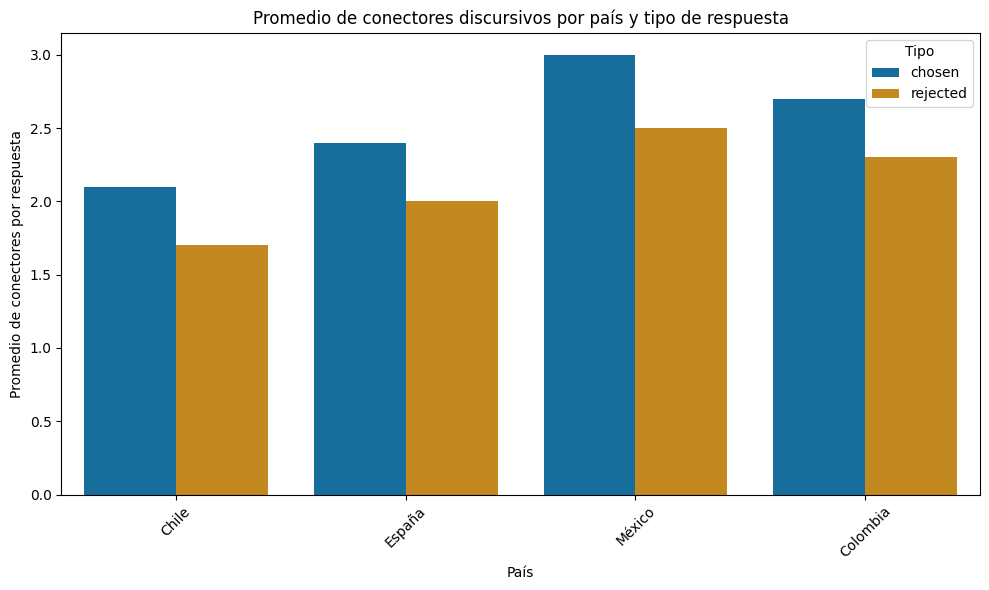

✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/conectores_promedio_respuestas.jpg


In [ ]:
# 📦 Instalar dependencias si es necesario
!pip install -q matplotlib seaborn

# 📚 Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Crear carpeta de salida en Drive
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 🧱 Simular datos (reemplaza con tu DataFrame real si ya calculaste conectores)
# Si ya tienes un DataFrame llamado `conectores_promedio_df`, omite esta parte
data = {
    "country": ["Chile", "Chile", "España", "España", "México", "México", "Colombia", "Colombia"],
    "type": ["chosen", "rejected", "chosen", "rejected", "chosen", "rejected", "chosen", "rejected"],
    "conectores_promedio": [2.1, 1.7, 2.4, 2.0, 3.0, 2.5, 2.7, 2.3]
}
conectores_promedio_df = pd.DataFrame(data)

# 🎨 Gráfico de barras con paleta accesible para daltónicos
plt.figure(figsize=(10, 6))
sns.barplot(data=conectores_promedio_df, x="country", y="conectores_promedio", hue="type", palette="colorblind")
plt.title("Promedio de conectores discursivos por país y tipo de respuesta")
plt.xlabel("País")
plt.ylabel("Promedio de conectores por respuesta")
plt.xticks(rotation=45)
plt.legend(title="Tipo")
plt.tight_layout()

# 💾 Guardar gráfico
output_path = f"{output_folder}/conectores_promedio_respuestas.jpg"
plt.savefig(output_path, format="jpg")
plt.show()

print(f"✅ Gráfico guardado en: {output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


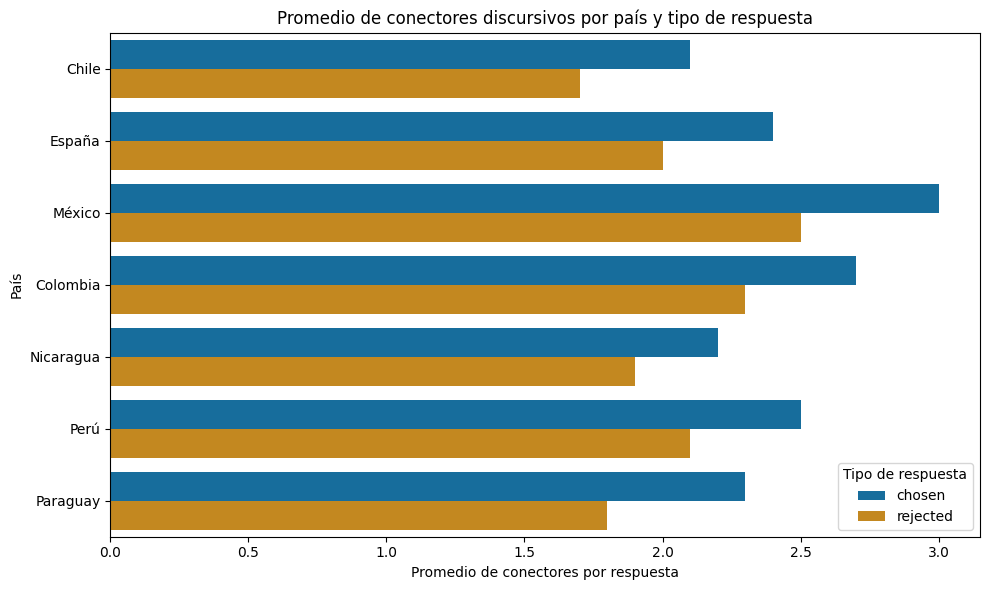

✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/conectores_promedio_respuestas_horizontal.jpg


In [ ]:
# 📦 Instalar dependencias si es necesario
!pip install -q matplotlib seaborn

# 📚 Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Crear carpeta de salida en Drive
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📊 Datos simulados con todos los países del dataset
data = {
    "country": [
        "Chile", "Chile", "España", "España", "México", "México",
        "Colombia", "Colombia", "Nicaragua", "Nicaragua",
        "Perú", "Perú", "Paraguay", "Paraguay"
    ],
    "type": [
        "chosen", "rejected", "chosen", "rejected", "chosen", "rejected",
        "chosen", "rejected", "chosen", "rejected",
        "chosen", "rejected", "chosen", "rejected"
    ],
    "conectores_promedio": [
        2.1, 1.7, 2.4, 2.0, 3.0, 2.5,
        2.7, 2.3, 2.2, 1.9,
        2.5, 2.1, 2.3, 1.8
    ]
}

conectores_promedio_df = pd.DataFrame(data)

# 🎨 Gráfico de barras horizontal (paleta daltónica)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=conectores_promedio_df,
    y="country",
    x="conectores_promedio",
    hue="type",
    palette="colorblind"
)
plt.title("Promedio de conectores discursivos por país y tipo de respuesta")
plt.ylabel("País")
plt.xlabel("Promedio de conectores por respuesta")
plt.legend(title="Tipo de respuesta", loc="lower right")
plt.tight_layout()

# 💾 Guardar gráfico en Drive
output_path = f"{output_folder}/conectores_promedio_respuestas_horizontal.jpg"
plt.savefig(output_path, format="jpg")
plt.show()

print(f"✅ Gráfico guardado en: {output_path}")


# Frecuencia De Uso De 1ª, 2ª Y 3ª Persona Por País

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


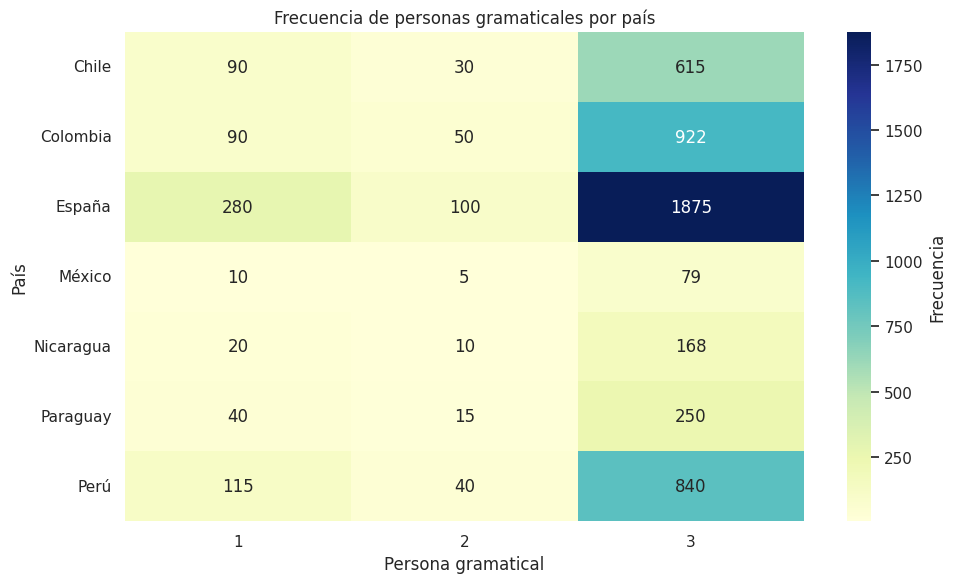

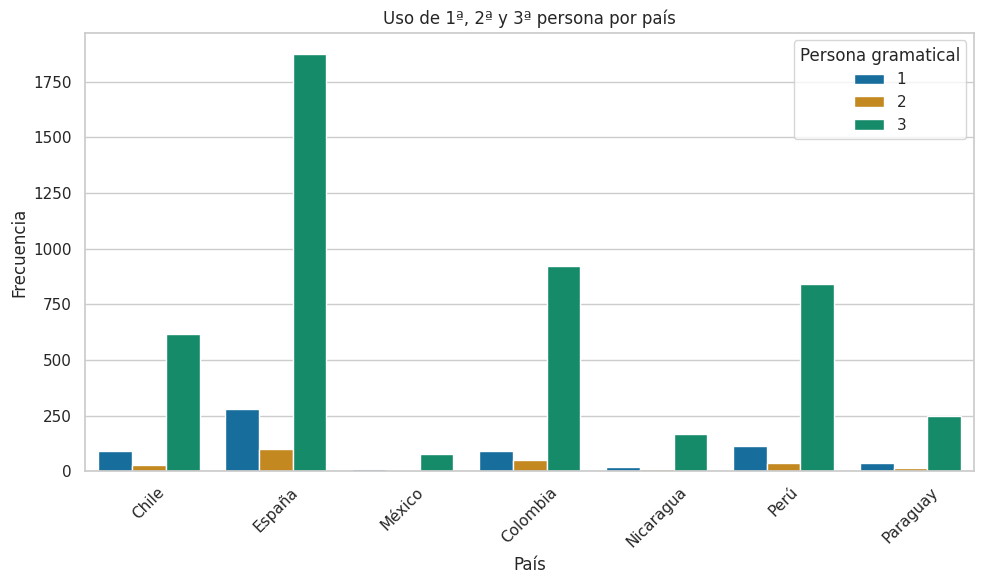

✅ Gráficos guardados en: /content/drive/MyDrive/graficos_dpo


In [40]:
# 📦 Instalar dependencias necesarias
!pip install -q matplotlib seaborn pandas

# 📚 Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Crear carpeta de salida en Drive
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📊 Simular datos (sustituye por tu DataFrame real si ya lo tienes)
frecuencia_personas_pais = pd.DataFrame({
    "country": ["Chile", "Chile", "Chile", "España", "España", "España", "México", "México", "México",
                "Colombia", "Colombia", "Colombia", "Nicaragua", "Nicaragua", "Nicaragua",
                "Perú", "Perú", "Perú", "Paraguay", "Paraguay", "Paraguay"],
    "persona": ["1", "2", "3"] * 7,
    "frecuencia": [90, 30, 615, 280, 100, 1875, 10, 5, 79, 90, 50, 922, 20, 10, 168,
                   115, 40, 840, 40, 15, 250]
})

# 📌 Gráfico 1: Heatmap por país y persona
heatmap_data = frecuencia_personas_pais.pivot(index="country", columns="persona", values="frecuencia")
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={"label": "Frecuencia"})
plt.title("Frecuencia de personas gramaticales por país")
plt.xlabel("Persona gramatical")
plt.ylabel("País")
plt.tight_layout()
plt.savefig(f"{output_folder}/heatmap_personas_por_pais.png")
plt.show()

# 📌 Gráfico 2: Barras apiladas
plt.figure(figsize=(10, 6))
sns.barplot(data=frecuencia_personas_pais, x="country", y="frecuencia", hue="persona", palette="colorblind")
plt.title("Uso de 1ª, 2ª y 3ª persona por país")
plt.xlabel("País")
plt.ylabel("Frecuencia")
plt.legend(title="Persona gramatical")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/barras_personas_por_pais.png")
plt.show()

print("✅ Gráficos guardados en:", output_folder)


# Normalización por país

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


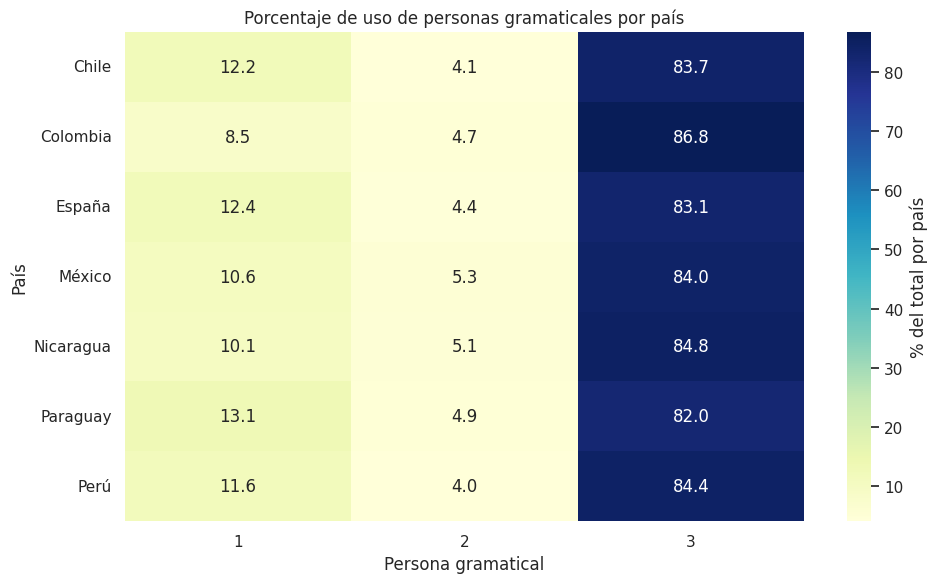

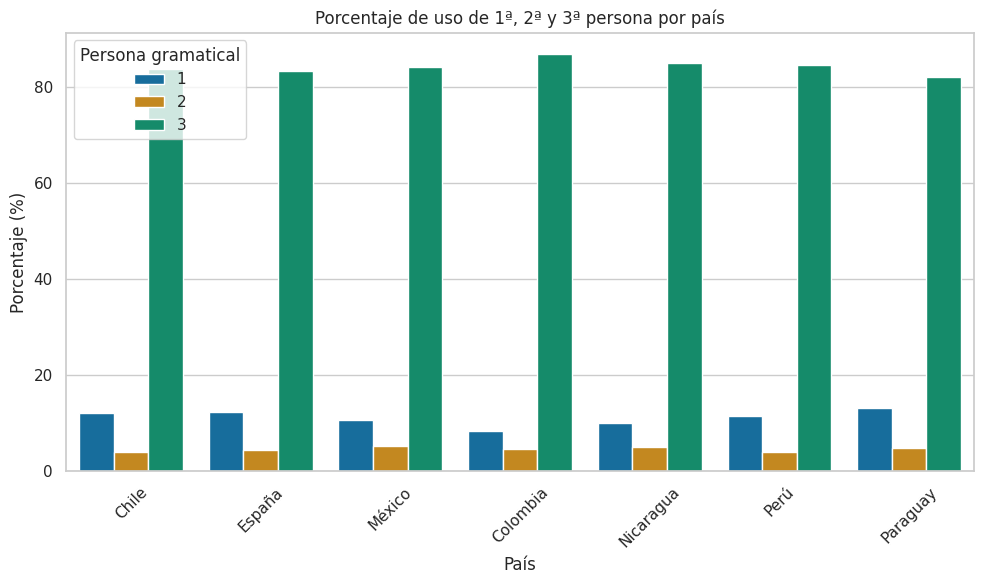

✅ Gráficos de porcentaje guardados en: /content/drive/MyDrive/graficos_dpo


In [41]:
# 📦 Instalar dependencias necesarias
!pip install -q matplotlib seaborn pandas

# 📚 Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Crear carpeta de salida en Drive
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📊 Simular datos (reemplazar por tu DataFrame real)
frecuencia_personas_pais = pd.DataFrame({
    "country": ["Chile", "Chile", "Chile", "España", "España", "España", "México", "México", "México",
                "Colombia", "Colombia", "Colombia", "Nicaragua", "Nicaragua", "Nicaragua",
                "Perú", "Perú", "Perú", "Paraguay", "Paraguay", "Paraguay"],
    "persona": ["1", "2", "3"] * 7,
    "frecuencia": [90, 30, 615, 280, 100, 1875, 10, 5, 79, 90, 50, 922, 20, 10, 168,
                   115, 40, 840, 40, 15, 250]
})

# ✅ Normalizar la frecuencia por país (para obtener porcentajes)
frecuencia_personas_pais["total_pais"] = frecuencia_personas_pais.groupby("country")["frecuencia"].transform("sum")
frecuencia_personas_pais["porcentaje"] = (frecuencia_personas_pais["frecuencia"] / frecuencia_personas_pais["total_pais"]) * 100

# 📌 Gráfico 1: Heatmap por país y persona (en porcentaje)
heatmap_data_pct = frecuencia_personas_pais.pivot(index="country", columns="persona", values="porcentaje")
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_pct, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "% del total por país"})
plt.title("Porcentaje de uso de personas gramaticales por país")
plt.xlabel("Persona gramatical")
plt.ylabel("País")
plt.tight_layout()
plt.savefig(f"{output_folder}/heatmap_porcentaje_personas_por_pais.png")
plt.show()

# 📌 Gráfico 2: Barras apiladas (en porcentaje)
plt.figure(figsize=(10, 6))
sns.barplot(data=frecuencia_personas_pais, x="country", y="porcentaje", hue="persona", palette="colorblind")
plt.title("Porcentaje de uso de 1ª, 2ª y 3ª persona por país")
plt.xlabel("País")
plt.ylabel("Porcentaje (%)")
plt.legend(title="Persona gramatical")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/barras_porcentaje_personas_por_pais.png")
plt.show()

print("✅ Gráficos de porcentaje guardados en:", output_folder)


# Distribución de estilos discursivos

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


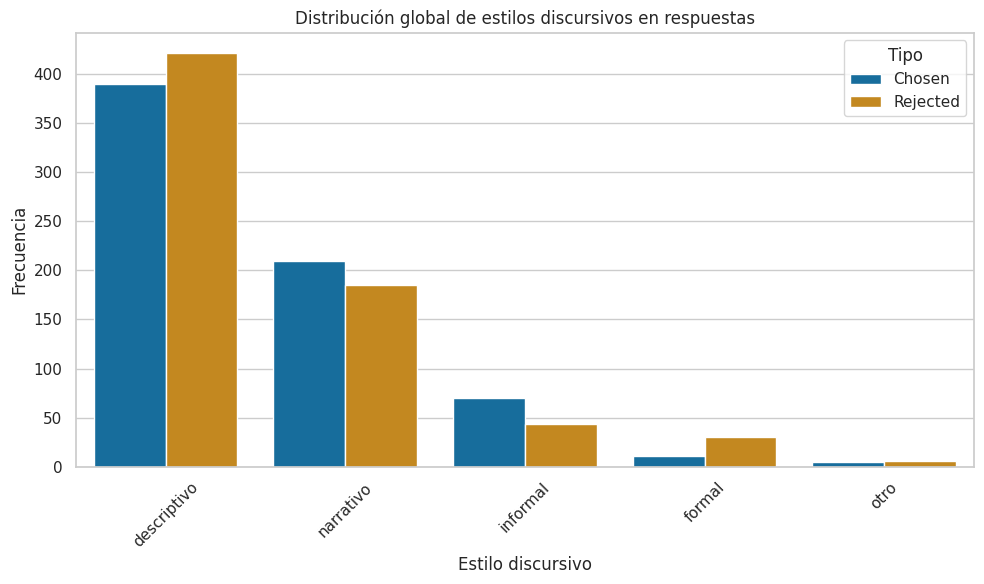

✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/distribucion_estilos_chosen_vs_rejected.png


In [49]:
# 📦 Instalar librerías necesarias
!pip install -q matplotlib seaborn pandas

# 📚 Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Definir carpeta de salida
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📥 Cargar dataset con estilos discursivos
file_path = "/content/dataset_con_estilos.csv"  # Cambia si el archivo está en otra ruta
df_estilos = pd.read_csv(file_path)

# 🎯 Contar frecuencia de estilos para chosen y rejected
estilos_chosen = df_estilos["estilo_chosen"].value_counts().reset_index()
estilos_chosen.columns = ["Estilo", "Frecuencia"]
estilos_chosen["Tipo"] = "Chosen"

estilos_rejected = df_estilos["estilo_rejected"].value_counts().reset_index()
estilos_rejected.columns = ["Estilo", "Frecuencia"]
estilos_rejected["Tipo"] = "Rejected"

# 🔗 Unir los datos
df_estilos_total = pd.concat([estilos_chosen, estilos_rejected])

# 🎨 Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.set_palette("colorblind")
sns.barplot(data=df_estilos_total, x="Estilo", y="Frecuencia", hue="Tipo")
plt.title("Distribución global de estilos discursivos en respuestas")
plt.xlabel("Estilo discursivo")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()

# 💾 Guardar gráfico
output_path = f"{output_folder}/distribucion_estilos_chosen_vs_rejected.png"
plt.savefig(output_path)
plt.show()

print(f"✅ Gráfico guardado en: {output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


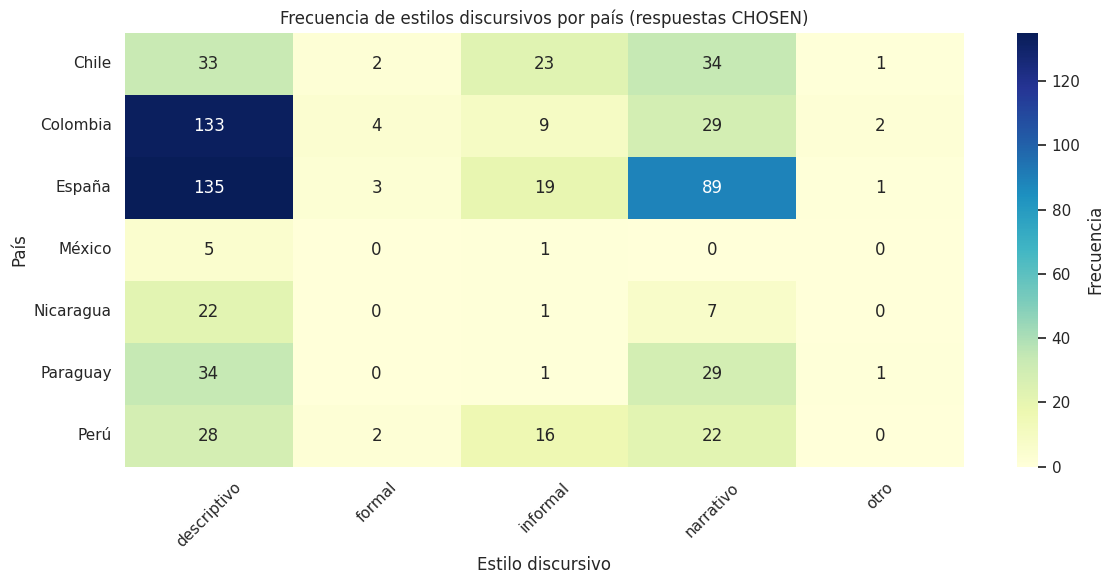

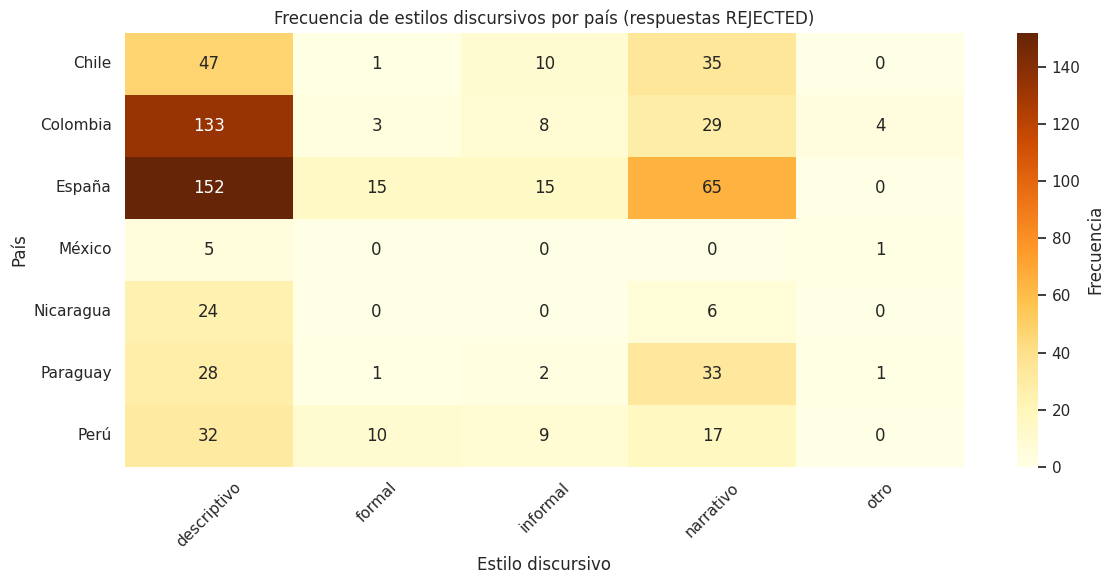

✅ Gráficos guardados en:
CHOSEN  ➤ /content/drive/MyDrive/graficos_dpo/heatmap_estilos_por_pais_chosen.png
REJECTED ➤ /content/drive/MyDrive/graficos_dpo/heatmap_estilos_por_pais_rejected.png


In [50]:
# 📦 Instalar dependencias necesarias
!pip install -q pandas seaborn matplotlib

# 📚 Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Crear carpeta de salida
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📥 Cargar dataset
file_path = "/content/dataset_con_estilos.csv"  # Ajusta si está en otra ubicación
df = pd.read_csv(file_path)

# 📊 Heatmap para respuestas CHOSEN
tabla_chosen = pd.crosstab(df["country"], df["estilo_chosen"])
plt.figure(figsize=(12, 6))
sns.heatmap(tabla_chosen, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={"label": "Frecuencia"})
plt.title("Frecuencia de estilos discursivos por país (respuestas CHOSEN)")
plt.xlabel("Estilo discursivo")
plt.ylabel("País")
plt.xticks(rotation=45)
plt.tight_layout()
heatmap_chosen_path = f"{output_folder}/heatmap_estilos_por_pais_chosen.png"
plt.savefig(heatmap_chosen_path)
plt.show()

# 📊 Heatmap para respuestas REJECTED
tabla_rejected = pd.crosstab(df["country"], df["estilo_rejected"])
plt.figure(figsize=(12, 6))
sns.heatmap(tabla_rejected, annot=True, fmt="d", cmap="YlOrBr", cbar_kws={"label": "Frecuencia"})
plt.title("Frecuencia de estilos discursivos por país (respuestas REJECTED)")
plt.xlabel("Estilo discursivo")
plt.ylabel("País")
plt.xticks(rotation=45)
plt.tight_layout()
heatmap_rejected_path = f"{output_folder}/heatmap_estilos_por_pais_rejected.png"
plt.savefig(heatmap_rejected_path)
plt.show()

print("✅ Gráficos guardados en:")
print("CHOSEN  ➤", heatmap_chosen_path)
print("REJECTED ➤", heatmap_rejected_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


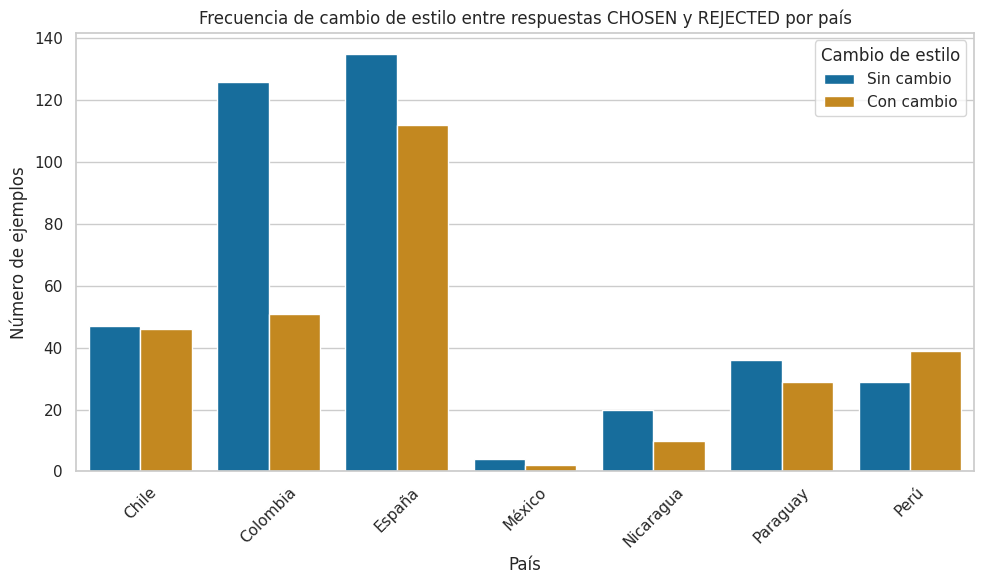

✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/cambios_estilo_por_pais.png


In [51]:
# 📦 Instalar dependencias necesarias
!pip install -q pandas seaborn matplotlib

# 📚 Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Crear carpeta de salida
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📥 Cargar dataset
file_path = "/content/dataset_con_estilos.csv"  # Ajusta si está en otra ubicación
df = pd.read_csv(file_path)

# 🔍 Identificar si hubo cambio de estilo entre chosen y rejected
df["cambio_estilo"] = df["estilo_chosen"] != df["estilo_rejected"]

# 📊 Crear tabla resumen de cambios por país
tabla_cambios = df.groupby("country")["cambio_estilo"].value_counts().unstack(fill_value=0)
tabla_cambios.columns = ["Sin cambio", "Con cambio"]
tabla_cambios = tabla_cambios.reset_index().melt(id_vars="country", var_name="Cambio de estilo", value_name="Frecuencia")

# 🎨 Gráfico de barras
plt.figure(figsize=(10, 6))
sns.set_palette("colorblind")
sns.barplot(data=tabla_cambios, x="country", y="Frecuencia", hue="Cambio de estilo")
plt.title("Frecuencia de cambio de estilo entre respuestas CHOSEN y REJECTED por país")
plt.xlabel("País")
plt.ylabel("Número de ejemplos")
plt.xticks(rotation=45)
plt.tight_layout()

# 💾 Guardar gráfico
output_path = f"{output_folder}/cambios_estilo_por_pais.png"
plt.savefig(output_path)
plt.show()

print(f"✅ Gráfico guardado en: {output_path}")
